# Introduction à l'apprentissage automatique - TP6 exercice 1 


### Classification d'images à la fin du XXème siècle et au début du XXIème siècle 


<br>

Le but de ce TP est de découvrir une application de la [vision par ordinateur](https://en.wikipedia.org/wiki/Computer_vision), la classification d'images.

On utilisera un sous-ensemble de la [base de données Caltech256](https://data.caltech.edu/records/nyy15-4j048), constitué d'images appartenant à 7 catégories, disponible sur Arche (et aussi [à cette URL](https://members.loria.fr/FSur/enseignement/apprauto/Caltech256_small.zip)). La base de donnée est volontairement réduite pour rester gérable pendant un TP, mais vous pouvez bien entendu tenter de traiter la base entière sur votre temps libre.

<br>
Commencez par charger et décompresser cette base d'images dans votre répertoire de travail, et visualisez les images qu'elle contient.

<br>

Le but est de prédire la catégorie d'une image de la base de test, connaissant les catégories auxquelles appartiennent les images de la base d'apprentissage. Il s'agit donc d'un problème de classification supervisée.

Les images ont des tailles différentes, de l'ordre de 300x200 pixels (certaines images, rares, ont des tailles de plus de 1000x1000 pixels). Ce sont des images en couleur, un pixel est donc décrit par un triplet de composantes Rouge, Vert, Bleu. Les composantes prennent des valeurs entre 0 et 255 (codage sur 8 bits), de manière à ce que (0,0,0) soit le noir, (255,255,255) le blanc, (0,255,0) le vert "pur", etc. Chaque image est donc décrite par approximativement 3x300x200=120000 valeurs variant entre 0 et 255. 

Le défi est de réduire la dimension des observations, en extrayant de chaque image une information pertinente représentée dans un espace de dimension "raisonnable", commun à toutes les images. Nous allons utiliser une méthode inspirée de celle présentée dans [cet article](https://members.loria.fr/FSur/enseignement/apprauto/chapelle99SVM.pdf) très célèbre de 1999: chaque image sera représentée par un vecteur de ${\mathbb R}^{8^3}={\mathbb R}^{512}$ obtenu en concaténant les histogrammes tridimensionnels des triplets (R,V,B) en chaque pixel, chaque composante étant discrétisée sur 8 "baquets" ( _bins_ ). 

<br>

On commence par importer des bibliothèques, et définir une fonction de visualisation de la base de test qui nous sera utile pour visualiser les performances des classifieurs.

In [1]:
from sklearn import svm, model_selection, neural_network, neighbors, linear_model, metrics, cluster
from sklearn.metrics.pairwise import chi2_kernel
import numpy as np
import os
import matplotlib.pyplot as plt

%matplotlib inline

def display_test(X_image_test,Y_test,Y_test_pred,txt):
    # pour visualiser les résultats de 120 images tirées au hasard dans la base test
    # paramètres: 
    # X_image_test: tableau des images de test 
    # Y_test: classes d'appartenance réelles
    # Y_test_pred: classes prédites
    # txt: légende de la figure
    alea=np.random.choice(len(X_image_test),size=120,replace=False)
    plt.figure(figsize=[18,12])    
    for n in range(120):
        plt.subplot(12,10,n+1,xticks=[],yticks=[])
        plt.imshow(X_image_test[alea[n]],cmap='gray')
        if Y_test_pred[alea[n]]==Y_test[alea[n]]:
            plt.text(0.1,0.1,str(Y_test_pred[alea[n]])+' / '+str(Y_test[alea[n]]),fontsize=8,bbox=dict(facecolor='white', alpha=1))
        else:
            plt.text(0.1,0.1,str(Y_test_pred[alea[n]])+' / '+str(Y_test[alea[n]]),fontsize=8,bbox=dict(facecolor='red', alpha=1))
    plt.suptitle('prediction '+txt+'  --  classe prédite / classe réelle')
    plt.show()
    



<br>

La cellule suivante permet de lire les données et stocker l'information dans des tableaux. Notez le nombre d'observations dans chaque classe (80% pour la base d'apprentissage, 20 % pour la base test). Constatez que les classes ont des effectifs assez différents. 

012.binoculars  - classe: 0  -  nombre d'observations: 216 
090.gorilla  - classe: 1  -  nombre d'observations: 212 
105.horse  - classe: 2  -  nombre d'observations: 200 
145.motorbikes-101  - classe: 3  -  nombre d'observations: 200 
205.superman  - classe: 4  -  nombre d'observations: 87 
251.airplanes-101  - classe: 5  -  nombre d'observations: 200 
253.faces-easy-101  - classe: 6  -  nombre d'observations: 200 
(8, 8, 8)
(8, 8, 8)
(8, 8, 8)
(8, 8, 8)
(8, 8, 8)
(8, 8, 8)
(8, 8, 8)
(8, 8, 8)
(8, 8, 8)
(8, 8, 8)
(8, 8, 8)
(8, 8, 8)
(8, 8, 8)
(8, 8, 8)
(8, 8, 8)
(8, 8, 8)
(8, 8, 8)
(8, 8, 8)
(8, 8, 8)
(8, 8, 8)
(8, 8, 8)
(8, 8, 8)
(8, 8, 8)
(8, 8, 8)
(8, 8, 8)
(8, 8, 8)
(8, 8, 8)
(8, 8, 8)
(8, 8, 8)
(8, 8, 8)
(8, 8, 8)
(8, 8, 8)
(8, 8, 8)
(8, 8, 8)
(8, 8, 8)
(8, 8, 8)
(8, 8, 8)
(8, 8, 8)
(8, 8, 8)
(8, 8, 8)
(8, 8, 8)
(8, 8, 8)
(8, 8, 8)
(8, 8, 8)
(8, 8, 8)
(8, 8, 8)
(8, 8, 8)
(8, 8, 8)
(8, 8, 8)
(8, 8, 8)
(8, 8, 8)
(8, 8, 8)
(8, 8, 8)
(8, 8, 8)
(8, 8, 8)
(8, 8, 8)
(8, 8, 8)
(8, 8, 8)


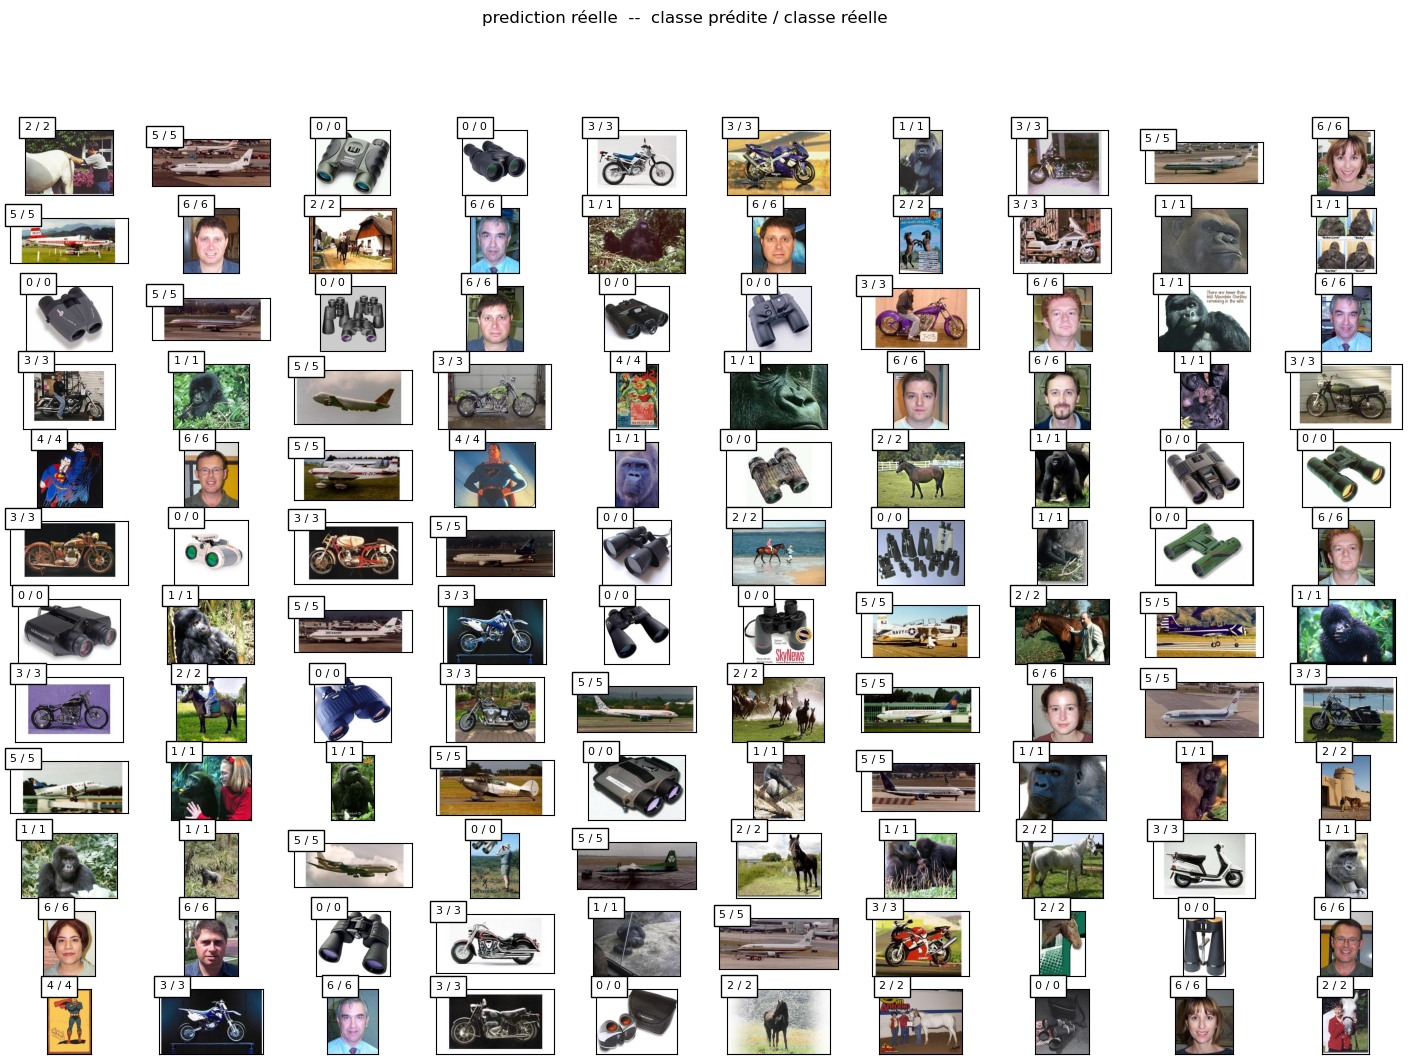


1052 observations dans la base d'apprentissage, chacune est décrite par un vecteur de dimension 512

263 observations dans la base de test, chacune est décrite par un vecteur de dimension 512


In [10]:
path="./Caltech256_small/" 
y=0
X_image=[]
X=[]
Y=[]
X_train=[]
X_test=[]

for directory in os.listdir(path):
    count = 0 # indice de l'image traitée dans le répertoire courant
    for file in os.listdir(path+directory):
        img = plt.imread(path+directory+"/"+file)
        if (len(img.shape)==2):  # au cas où on lit une image en niveaux de gris, on crée une image RBV ou R=V=B
            img=np.repeat(img[:,:,np.newaxis],3,axis=2)
        X_image.append(img)
        Y.append(y)
        count = count+1
    print("%s  - classe: %d  -  nombre d'observations: %d " % (directory,y,count))
    y = y+1
    
X_image_train, X_image_test, Y_train, Y_test = model_selection.train_test_split(X_image, Y, test_size=0.2, random_state=1)


for i in range(len(X_image_train)):
    img=X_image_train[i]
    h,b = np.histogramdd(img.reshape(-1,3),range=((0,255),(0,255),(0,255)),bins=8)  # on calcule l'histogramme 3D, chaque direction est discrétisée sur 8 bins
    h = h/(img.shape[0]*img.shape[1])  # on normalise les valeurs: (nombre de pixels dans un bin donné) / (nombre de pixels dans l'image)
    X_train.append(h.flatten())

for i in range(len(X_image_test)):
    img=X_image_test[i]
    h,b = np.histogramdd(img.reshape(-1,3),range=((0,255),(0,255),(0,255)),bins=8)  # on calcule l'histogramme 3D, chaque direction est discrétisée sur 8 bins
    h = h/(img.shape[0]*img.shape[1])  # on normalise les valeurs: (nombre de pixels dans un bin donné) / (nombre de pixels dans l'image)
    X_test.append(h.flatten())
        
display_test(X_image_test,Y_test,Y_test,'réelle')

print("\n%d observations dans la base d'apprentissage, chacune est décrite par un vecteur de dimension %d" % (len(X_train), len(X_train[0])) )
print("\n%d observations dans la base de test, chacune est décrite par un vecteur de dimension %d" % (len(X_test), len(X_test[0])) )


__Question 1__: `np.histogramdd` renvoie le nombre de pixels de l'image `img` dont les composantes (R,G,B) tombent dans un cube de la forme $[32i,32(i+1)]\times[32j,32(j+1)]\times[32k,32(k+1)]$, pour $i,j,k \in \{0,1,\dots,7\}$ (d'où les 8 "baquets" par composante couleur). Selon vous, pourquoi normalise-t-on les valeurs stockées dans les histogrammes, et quel est l'intérêt pour ces images de tailles différentes? 

<font color=red>
    
1. Nous normalisons car il faut comparer les images de même taille pour eviter que la modèle utilise le taille comme paramatre de comparaison. Par ailleurs, le contenu de le histogram est l'important.
2. Car dans le monde réele (échantillon de test) il existe le differente type de taille et donc la modelè dois de faire la apprendisage sur ça.

</font>

Les deux cellules suivantes permettent de visualiser une image et son histogramme normalisé pour mieux comprendre les descripteurs d'images utilisés. On représente l'histogramme 3D comme un _scatter plot_ tridimensionnel où chaque triplet (R,V,B) est représenté comme un disque de rayon proportionnel à la fréquence du triplet dans l'image, la couleur du disque étant déterminée par (R,V,B). Les couleurs les plus fréquentes dans l'image seront donc représentées par des "gros" disques. 

Le code est adapté de: https://staff.fnwi.uva.nl/r.vandenboomgaard/IPCV20172018/LectureNotes/IP/Images/ImageHistograms.html

Constatez le lien entre l'allure de l'histogramme (que vous pouvez "tourner" à la souris si vous n'êtes pas dans VSCode et avez pu utiliser `%maplotlib notebook`) et le contenu de l'image.

<br>

_Remarque_: si vous avez un message d'erreur à l'exécution de la cellule suivante, mettez à jour `ipython`, en exécutant l'une ou l'autre de ces instructions dans un terminal:

* si vous utilisez la distribution anaconda: `conda update ipython`
* sinon: `pip install --upgrade ipython`

In [11]:
from mpl_toolkits.mplot3d import Axes3D

def histogram3dplot(h, e):
    """
    Visualize a 3D histogram
    source: https://staff.fnwi.uva.nl/r.vandenboomgaard/IPCV20172018/LectureNotes/IP/Images/ImageHistograms.html
    
    Parameters
    ----------

    h: histogram array of shape (M,N,O)
    e: list of bin edge arrays (for R, G and B)
    """
    M, N, O = h.shape
    idxR = np.arange(M)
    idxG = np.arange(N)
    idxB = np.arange(O)

    R, G, B = np.meshgrid(idxR, idxG, idxB, indexing='ij')   # change w.r.t. original code
    a = np.diff(e[0])[0]
    b = a/2
    R = a * R + b

    a = np.diff(e[1])[0]
    b = a/2
    G = a * G + b

    a = np.diff(e[2])[0]
    b = a/2
    B = a * B + b

    colors = np.vstack((R.flatten(), G.flatten(), B.flatten())).T/255
    h = h / np.sum(h)
    f = plt.figure(figsize=[8,6])
    ax = f.add_subplot(111, projection='3d')     
    mxbins = np.array([M,N,O]).max()
    ax.scatter(R.flatten(), G.flatten(), B.flatten(), s=h.flatten()*(256/mxbins)**3/2, c=colors)

    ax.set_xlabel('Rouge')
    ax.set_ylabel('Vert')
    ax.set_zlabel('Bleu')

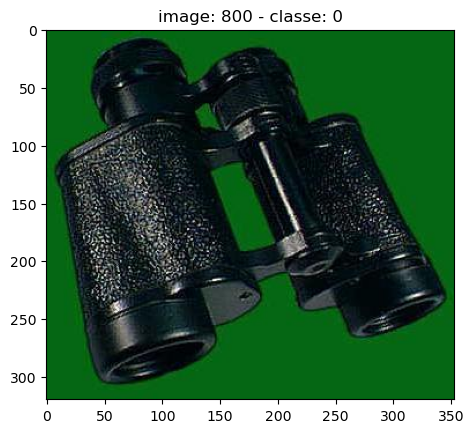

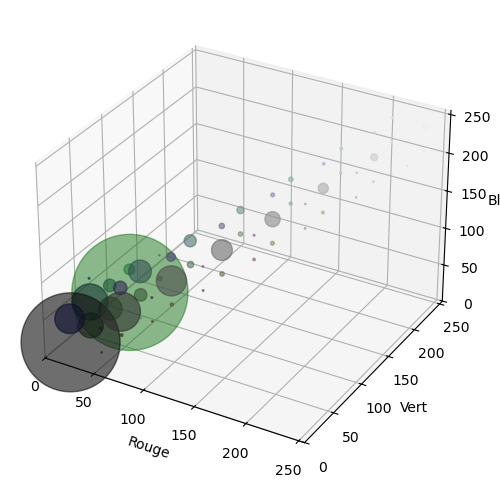

In [18]:
# exemple: visualisation d'une image
n_image=800  # indice d'une image de la base d'apprentissage, essayez aussi d'autres valeurs

plt.figure()
plt.imshow(X_image_train[n_image])
plt.title("image: %d - classe: %d" % (n_image,Y_train[n_image]))
plt.show()

histogram3dplot(X_train[n_image].reshape(8,8,8),b)
plt.show()

__Question 2__: testez différents algorithmes de classification sur les histogrammes vus comme des vecteurs de ${\mathbb R}^{256}$ (bases  `X_train` et `X_test` déjà construites): machine à vecteur support (SVM), perceptrion multicouche (MLP), régression logistique (LR), plus proches voisins (NN):

<br>

* Pour les SVM, vous testerez les noyaux `linear`, `rbf`, et `chi2_kernel`.

On peut utiliser une SVM avec un noyau du $\chi^2$ (on sait que cette métrique est bien adaptée à la comparaison d'histogrammes d'après le cours de statistique) à l'aide de:
```python 
SVM = svm.SVC(kernel=chi2_kernel)
``` 
avec l'import préalable (déjà fait dans la première cellule de ce carnet):
```python
from sklearn.metrics.pairwise import chi2_kernel
```
Ce mode de définition d'un noyau rend la modification du paramètre $\gamma$ plus compliquée, on se contentera donc de la valeur par défaut (idem pour `rbf`). Voir [cette page](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.chi2_kernel.html) pour la définition de ce noyau.

Pour les trois noyaux, vous fixerez les valeurs de l'hyperparamètres $C$ à l'aide de `GridSearchCV`.

<br>

* Pour les MLP, vous testerez un réseau à une couche cachée à 20 neurones et un autre avec deux couches cachées à 20 neurones, dont vous fixerez l'hyperparamètre de régularisation `alpha`  à l'aide de `GridSearchCV`. Vous fixerez `max_iter=500` et utiliserez `solver='lbfgs'` (bien adapté aux petites bases de données d'après la documentation de scikit-learn).

<br>

* pour LR, vous fixerez également l'hyperparamètre de régularisation par `GridSearchCV`.

<br>

* pour les NN, vous testerez 1-ppv et 5-ppv.


<br>

Pour chaque classifieur, vous afficherez le score de classification sur la base de test, la matrice de confusion, et la visualisation de la classification obtenue à l'aide de la fonction `display_test` fournie.

Quel est le score de classification "minimal" auquel se comparer ?

SVM - accuracy linear: 0.551331


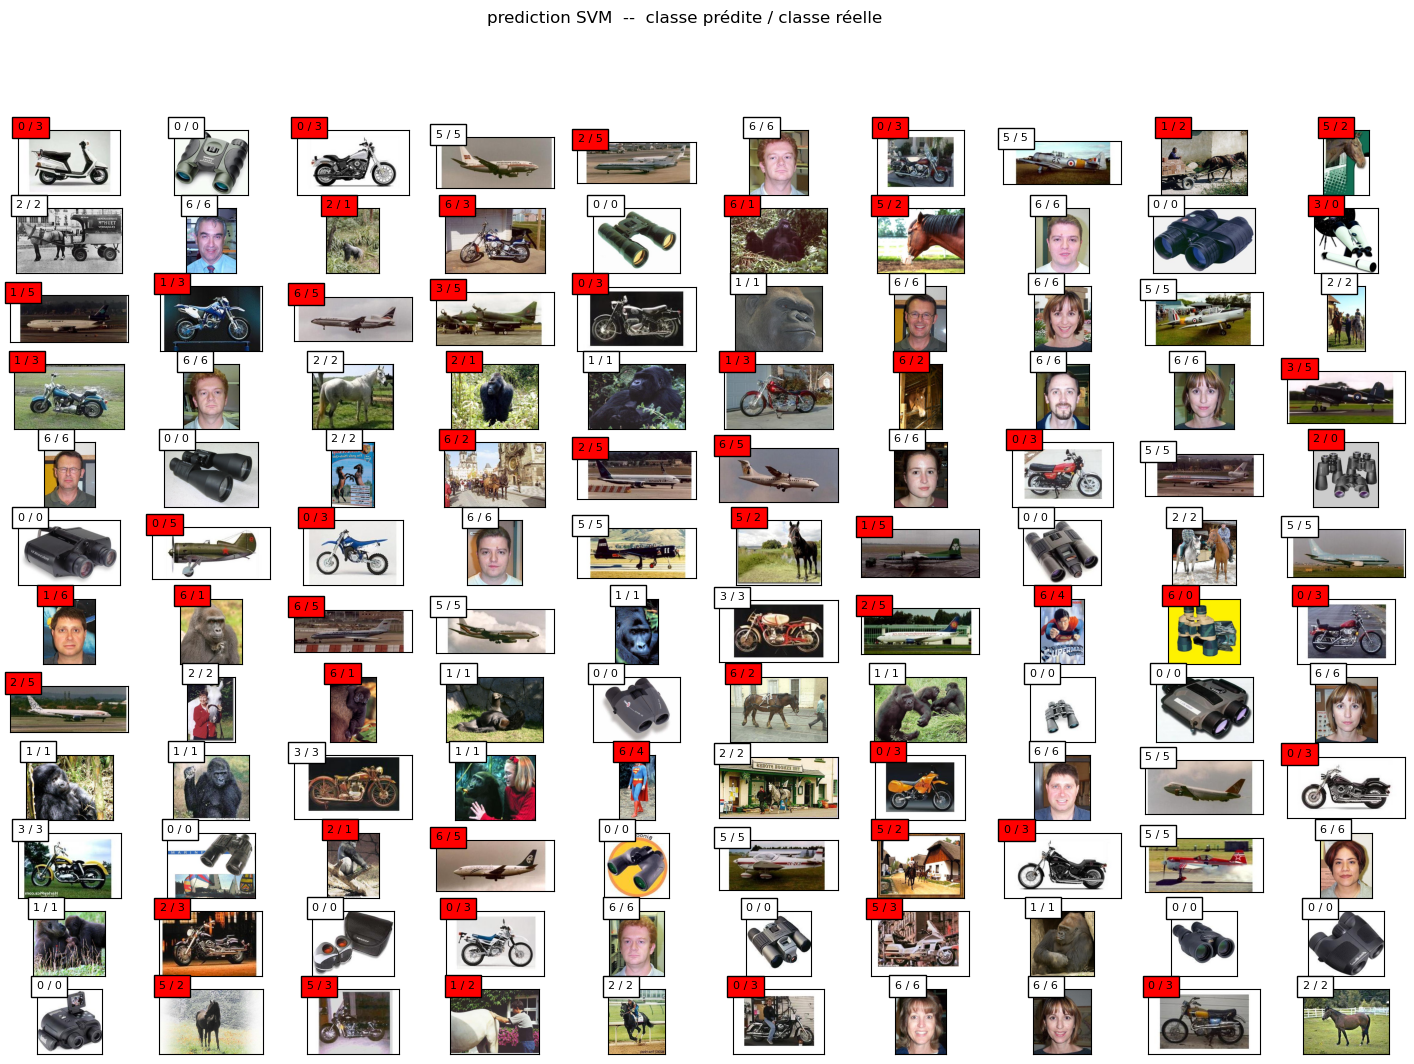

SVM - accuracy rbf: 0.163498


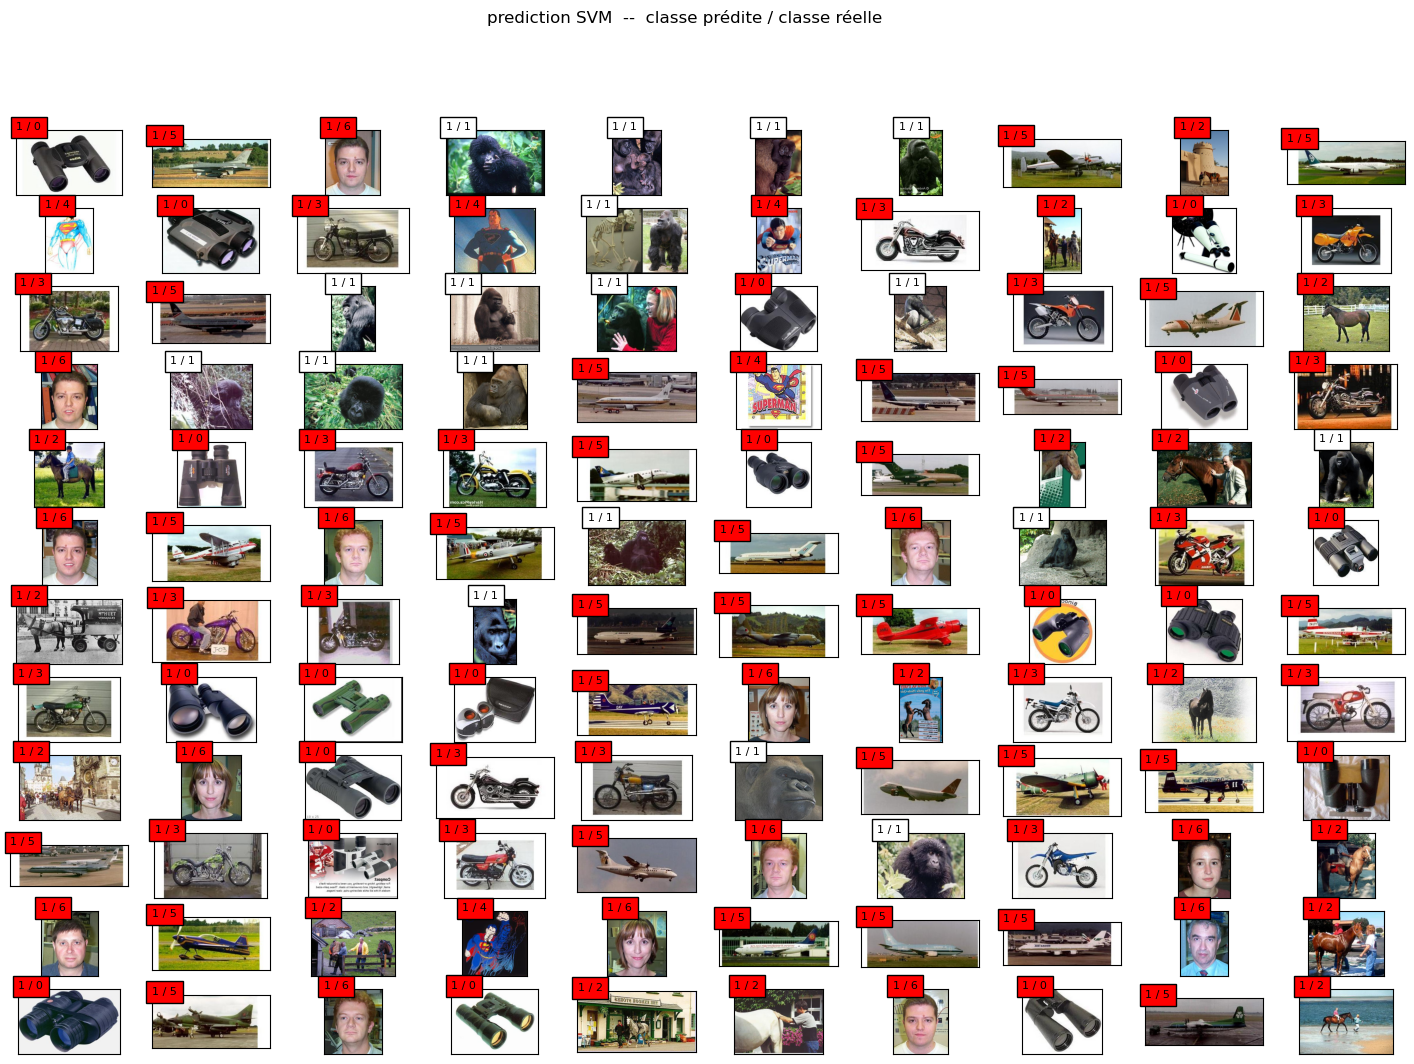

SVM - accuracy chiq2: 0.771863


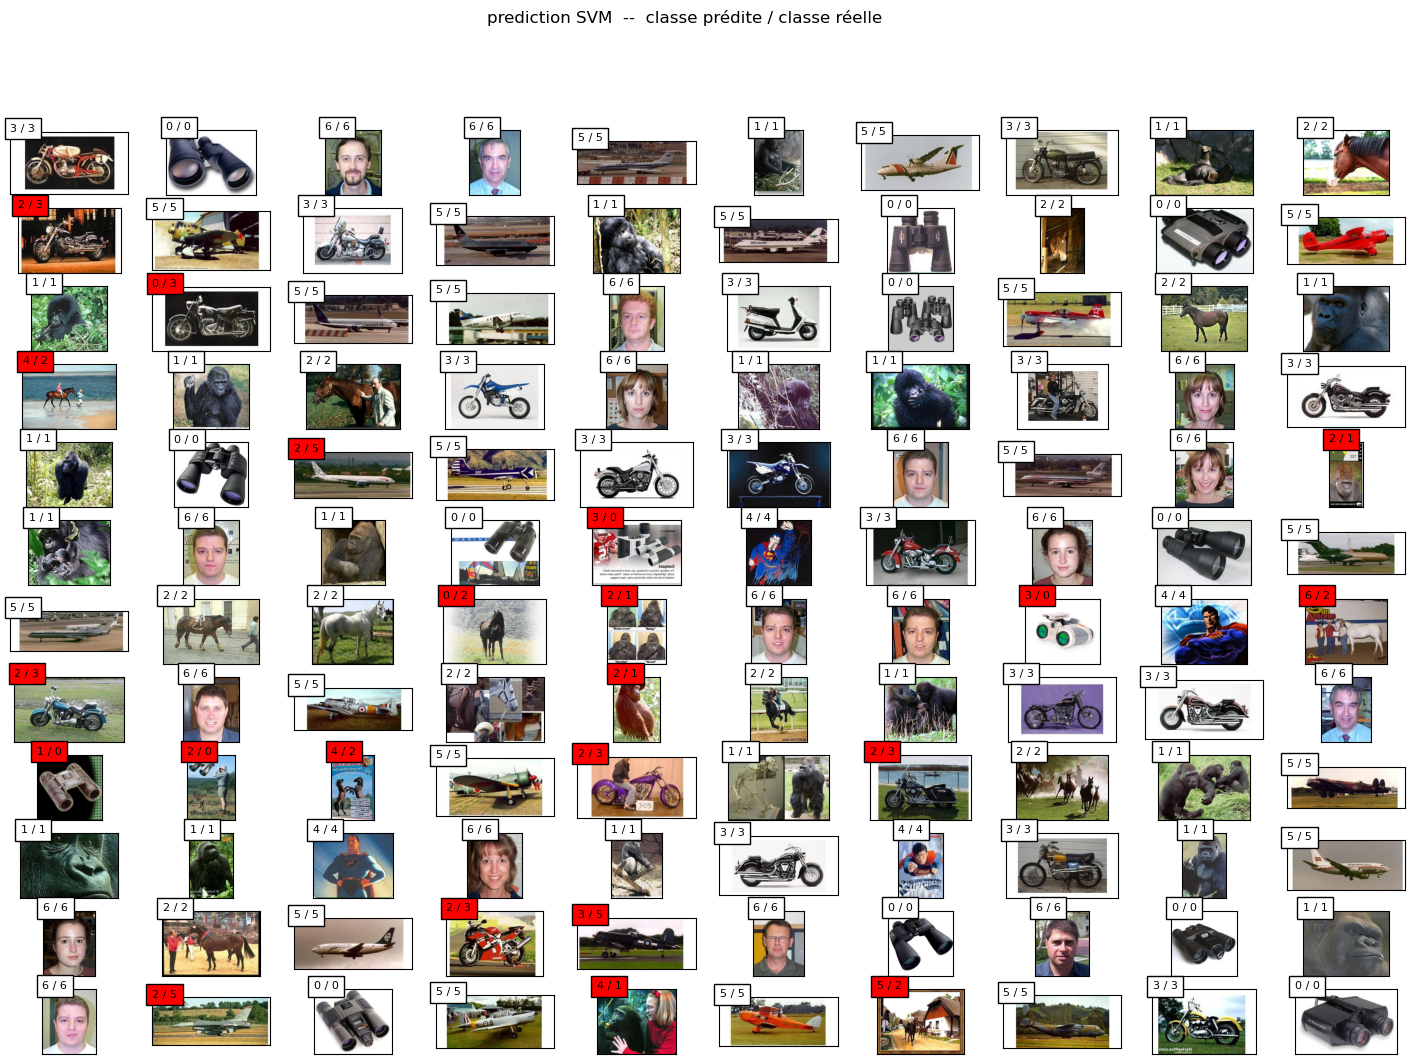

In [21]:
from sklearn.metrics.pairwise import chi2_kernel, linear_kernel, rbf_kernel

# gridsearch pour SVM

C_range=10**np.arange(-4,4.5,1)
parameters = {'C':C_range}

## Linear
SVM = svm.SVC(kernel=linear_kernel)
SVM.fit(X_train,Y_train)
Y_test_pred = SVM.predict(X_test)
print("SVM - accuracy linear: %f" % metrics.accuracy_score(Y_test,Y_test_pred))

display_test(X_image_test,Y_test,Y_test_pred,'Linear SVM')

SVM = svm.SVC(kernel=rbf_kernel)
SVM.fit(X_train,Y_train)
Y_test_pred = SVM.predict(X_test)
print("SVM - accuracy rbf: %f" % metrics.accuracy_score(Y_test,Y_test_pred))

display_test(X_image_test,Y_test,Y_test_pred,'RBF SVM')

# Chiq 2
SVM = svm.SVC(kernel=chi2_kernel)
SVM.fit(X_train,Y_train)
Y_test_pred = SVM.predict(X_test)
print("SVM - accuracy chiq2: %f" % metrics.accuracy_score(Y_test,Y_test_pred))

display_test(X_image_test,Y_test,Y_test_pred,'Chiq2 SVM')

c:\Users\diogo\miniconda3\envs\ia\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\diogo\miniconda3\envs\ia\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\diogo\miniconda3\envs\ia\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status

MLP - accuracy: 0.699620


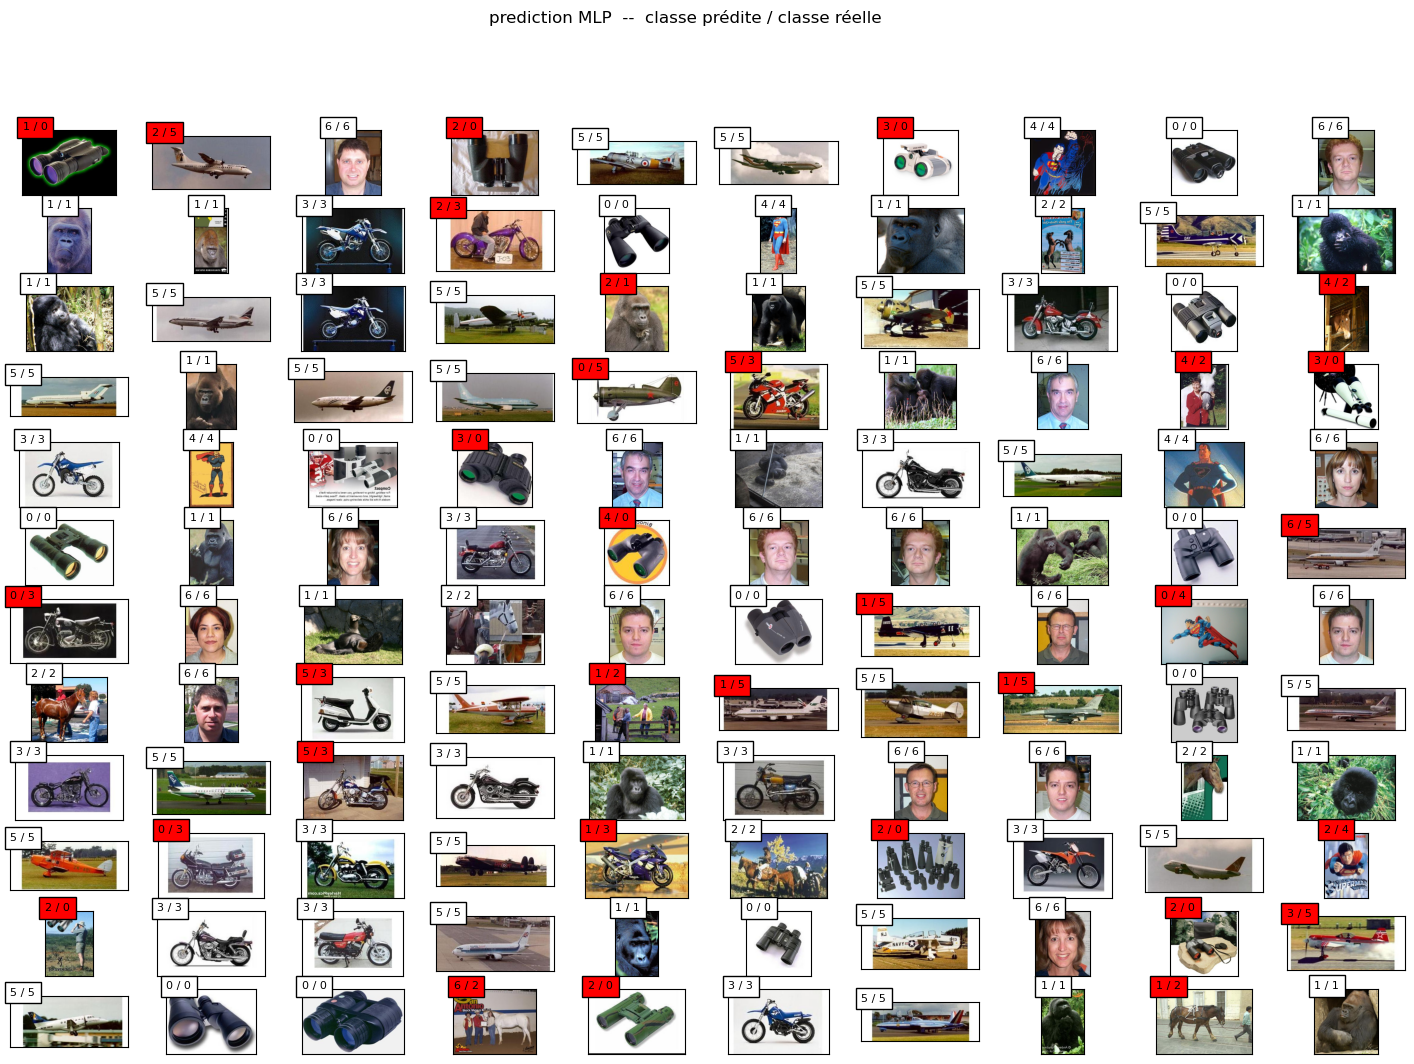

c:\Users\diogo\miniconda3\envs\ia\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\diogo\miniconda3\envs\ia\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\diogo\miniconda3\envs\ia\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status

In [ ]:
# gridsearch pour MLP

from sklearn.neural_network import MLPClassifier 
from sklearn.model_selection import GridSearchCV
alpha_range=10**np.arange(-4.,4.5,1)
parameters = {'alpha':alpha_range }

# Vous aurez sans doute des avertissements sur des problèmes de convergence.
# Néanmoins, on souhaite garder des temps de calculs raisonnables et on améliorera les résultats dans l'ex 2

# votre code ici:
MLP = MLPClassifier(solver='lbfgs', max_iter=500, hidden_layer_sizes=[20,])
model_test_grid = GridSearchCV(MLP, parameters, cv=5)
model_test_grid.fit(X_train,Y_train)
Y_test_pred = model_test_grid.predict(X_test)
print("MLP - accuracy: %f" % metrics.accuracy_score(Y_test,Y_test_pred))

display_test(X_image_test,Y_test,Y_test_pred,'MLP')

MLP = MLPClassifier(solver='lbfgs', max_iter=500, hidden_layer_sizes=[20,20,20])
model_test_grid = GridSearchCV(MLP, parameters, cv=5)
model_test_grid.fit(X_train,Y_train)
Y_test_pred = model_test_grid.predict(X_test)
print("MLP - accuracy: %f" % metrics.accuracy_score(Y_test,Y_test_pred))


In [33]:
# gridsearch pour LR


C_range=10**np.arange(-4,4.5,1)
parameters = {'C':C_range}

# votre code ici:
LR = linear_model.LogisticRegression()
model_test_grid = GridSearchCV(LR, parameters, cv=5)
model_test_grid.fit(X_train,Y_train)
Y_test_pred = model_test_grid.predict(X_test)
print("LR - accuracy: %f" % metrics.accuracy_score(Y_test,Y_test_pred))

display_test(X_image_test,Y_test,Y_test_pred,'Linear Reqression')


c:\Users\diogo\miniconda3\envs\ia\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\diogo\miniconda3\envs\ia\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

LR - accuracy: 0.665399


c:\Users\diogo\miniconda3\envs\ia\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\diogo\miniconda3\envs\ia\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

Response : 
Le chiq2 est avec 77% de acuracy

In [ ]:
%matplotlib inline  
# il faut passer à la présentation non-interactive des graphiques (si ce n'est pas déjà fait) pour utilisation de la fonction display_test

# classification avec les hyperparamètres optimaux

# votre code ici

__Question 3__: 

Quelle est la nature de l'information permettant la classification? En quel sens reconnaît-on les différentes catégories?

Quel modèle d'apprentissage présente les meilleures performances ? A partir de quel taux de classifications correctes
le modèle "apprend"-il quelque chose ?

Quelle est la classe la plus "facile" à reconnaître, et pourquoi ? La plus difficile ?

Que dire des biais de la base d'apprentissage ? En 2015, l'application photo de Google a fait les titres de la presse grand public pour avoir étiqueté des étudiants à la peau noire comme "gorilles". Voici la ["solution" de Google à l'époque](https://www.wired.com/story/when-it-comes-to-gorillas-google-photos-remains-blind/).


<font color=red>

La nature de l'information s'incarne sur RGB, de base un valeur numerique. Par ailleurs, le reconnaiscance s'agit de la position de la derniere convolution, de coup le softmax.

La modèle de meilleures performance est SVM chiq2.

</font>

<br>

## Compléments d'information (après la séance de TD)

L'[article](https://members.loria.fr/FSur/enseignement/apprauto/chapelle99SVM.pdf) de Chapelle et al. cité en introduction teste différents noyaux pour les SVM. On voit que la SVM avec noyau du $\chi^2$ est parmi les plus performantes. Notons que la base de données de cet article est différente de celle que nous utilisons.


<br>

Cette méthode correspond à l'état de l'art scientifique à la fin des années 1990 / début des années 2000.

En 2004-2005 sont apparus de nouveaux algorithmes basés sur la notion de "sac de mots visuels" et les descripteurs SIFT (évoqués en cours), dont une description accessible est [disponible ici](https://towardsdatascience.com/bag-of-visual-words-in-a-nutshell-9ceea97ce0fb) par exemple. Il s'agit d'une adaptation aux images des sacs de mots que l'on vous a présentés au TP2.

Depuis 2012, les méthodes basées sur les [réseaux de neurones convolutifs](https://medium.com/@tifa2up/image-classification-using-deep-neural-networks-a-beginner-friendly-approach-using-tensorflow-94b0a090ccd4) obtiennent les meilleurs résultats. Elles font l'objet de l'exercice 2.

<br>

Notez la remarque dans l'article de Chapelle et al. de 1999, Section IV A p. 4 à propos du noyau du $\chi^2$: " _It is not known if the kernel satisfies Mercer’s condition_ ". Ceci a été démontré dans [cet article](https://people.eecs.berkeley.edu/~malik/papers/FBCM-nystrom.pdf) de 2004 (annexe B).

<br>

_Références bibliographiques:_
- O. Chapelle, P. Haffner, V. Vapnik. _Support Vector Machines for Histogram-Based Image Classification_, IEEE Transactions on Neural Networks, vol. 10, no. 5, 1999.
- C. Fowlkes, S. Belongie, F. Chung, J. Malik. _Spectral Grouping Using the Nyström Method_, IEEE Transactions on Pattern Analysis and Machine Intelligence, vol. 26, no. 2, 2004.